In [ ]:
!git clone https://github.com/ValerF800/number_recognition.git
import sys
sys.path.append('number_recognition')

!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

!pip install pytelegrambotapi

Cloning into 'number_recognition'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 10 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), done.
     |████████████████████████████████| 61kB 700kB/s 
     |████████████████████████████████| 61kB 6.9MB/s 
     |████████████████████████████████| 163kB 18.1MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60964 sha256=26471ca63ab993bff790e53f77da96459fd159480f48bae4d4dddd29757e5567
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12421 sha256=1bdae78dfbab03f13fa41f17238b755ab5c241dc4fc4556fbd6bb3c824ded950
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Su

In [ ]:
import numpy as np
import torch
import utils
from PIL import Image
from google.colab.patches import cv2_imshow
import albumentations as albu
from albumentations.pytorch import ToTensor
import cv2
from time import time
temp = r'[a-z][0-9]{3}[a-z]{2}[0-9]{2,3}'
import re
import os
from skimage import measure
from skimage.morphology import convex_hull_image
import matplotlib.pyplot as plt

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model = smp.Unet('efficientnet-b4', activation='sigmoid', encoder_weights='imagenet', encoder_depth=4, decoder_channels=[128, 64, 32, 16]).to(device)

print('loading model unet...\n')
model.load_state_dict(torch.load('/content/drive/My Drive/WeightNet/model(1.0).pth'))

def prepare_image(path_name):
  image_orig = cv2.imread(path_name)
  img_shape = image_orig.shape
  image = augmentations()(image=image_orig)['image']
  
  return image.unsqueeze(0), image_orig, img_shape


def augmentations():
  transforms = []
  transforms.extend([
                albu.Resize(256,256),
                ToTensor()
  ])
  return albu.Compose(transforms)

nomer_aug = albu.Compose([
                          albu.Resize(32, 128),
                          albu.CLAHE(always_apply=True),
                          ToTensor()
])

sys.path.append('/content/drive/My Drive')
import rectDetector
rectDetect = rectDetector.RectDetector()

full_path_image = '/content/drive/My Drive/DataCars'
list_cars = os.listdir(full_path_image)

import crnn2 as crnn


alphabet = '1234567890abekmhopctyx'

nclass = len(alphabet) + 1
nc = 3
nh = 256
imgH = 64
preds_size = torch.tensor([33])
converter = utils.strLabelConverter(alphabet)
crnn = crnn.CRNN(imgH, nc, nclass, nh).to(device)
print('loading crnn model...\n')
crnn.load_state_dict(torch.load('/content/drive/My Drive/WeightNet/OCR(2.0)'))
crnn.eval()

def detect(path_name_img):

  image, image_orig, img_shape = prepare_image(path_name_img)
  test_output = model(image.to(device))

  w, h, _ = img_shape
  mask_gray = cv2.resize((test_output[0].cpu().detach().numpy().squeeze() > 0.6).astype(np.uint8), dsize=(h, w))
  mask_rgb = cv2.cvtColor(mask_gray, cv2.COLOR_GRAY2RGB)
  contours, hierarchy = cv2.findContours(mask_gray.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # image_orig_copy = image_orig.copy()

  # outputs = find_rect(mask_rgb, image_orig_copy)
  

  count_contours = len(contours)
  outputs = []
  mask_list = []
  nomer_list = []
  recog_dict = {}

  for cont in range(count_contours):
  # делаем несколько масок
    mask = np.zeros_like(mask_gray)
    mask = cv2.drawContours(mask, [contours[cont]], -1, (255,0,0), 3, cv2.LINE_AA, np.expand_dims(hierarchy[:, cont], axis=1), 1)
    mask = convex_hull_image(mask).astype(np.uint8)
    if np.sum(mask) < 1500:
      continue

    mask_list.append(mask)
    a3 = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    cord = rectDetect.detect([a3 * 255])
# x1, x2, x3, x4 = cord[0]

    zones = rectDetect.get_cv_zonesBGR(image_orig.copy(), cord)
    outputs.append(zones[0])



  for nomer in outputs:
    image = nomer_aug(image=nomer)['image'].unsqueeze(0)
    preds1 = crnn(image.to(device))
    preds1 = preds1.view(-1, 33, 1, 23)
    conf = [0, 0]

    for idx, head in enumerate(preds1):
      _, preds = head.max(2)
      batch = preds.size(1)
      preds = preds.transpose(1, 0).contiguous().view(-1)

      sim_pred = converter.decode(preds.data, preds_size.data, raw=False)
      postpro = re.findall(temp, sim_pred)
    
      sim_pred = postpro[0] if postpro != [] else 'Unknown'
      conf[idx] = sim_pred

    # if conf[0] == conf[1]:
    #   nomer_list.append(conf[0])
    # else:
    #   nomer_list.append('Unknown')
    nomer_list.append(conf)

  return nomer_list, outputs, mask_rgb, image_orig 

def Detecting(chat_id, path, flag=False):
  try:
    a = time()
    text_list, zones_nomer, mask_, image_arr = detect(path)
    print(time() - a, 'time detect')
  except:
    return bot.send_message(chat_id, 'Не найден номер')
  b = time()
  image_ = Image.fromarray(image_arr[..., ::-1])
  if flag:
    bot.send_photo(chat_id, image_, caption='Исходная картинка')
  for k_nomer in range(len(zones_nomer)):
    caption_ = f'First model: {text_list[k_nomer][0].upper()}\nSecond model: {text_list[k_nomer][1].upper()}'
    bot.send_photo(chat_id, Image.fromarray(zones_nomer[k_nomer]), caption=caption_)
  mask_ = Image.fromarray(mask_ * 255)
  bot.send_photo(chat_id, mask_, reply_markup=markup)
  print(time() - b, 'time send photo')

import telebot
from telebot import types
import random

print('Telegram bot activate!\n')

markup = types.ReplyKeyboardMarkup(one_time_keyboard=True, selective=False)
itembtn1 = types.KeyboardButton('Отправить фото из нашего набора')
markup.add(itembtn1)


bot = telebot.TeleBot('1200244813:AAF_DPJcNp4G4TO4fbBdTOEpq6n-_IFROV0')

@bot.message_handler(commands=['start'])
def start_message(message):
    chat_id = message.chat.id
    bot.send_message(chat_id, 'Привет, чтобы распознать номер - отправь изображение', reply_markup=markup)


@bot.message_handler(content_types=['photo'])
def detect_plate(message):
    chat_id = message.chat.id
    file = bot.get_file(message.photo[-1].file_id)

    downloaded_file = bot.download_file(file.file_path)

    with open("image.jpg", 'wb') as new_file:
        new_file.write(downloaded_file)

    path_name = 'image.jpg'
    a = time()
    Detecting(chat_id, path_name, flag=False)
    print(time() - a)


@bot.message_handler(content_types=['text'])
def send_text(message):
    chat_id = message.chat.id
    if message.text.lower() == 'привет':
        bot.send_message(chat_id, 'Привет, жду сообщений')
    else:
      path_name = os.path.join(full_path_image, list_cars[random.choice(range(len(list_cars)))])
      #a = time()
      Detecting(chat_id, path_name, flag=True)
      #print(time() - a)



bot.polling()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth



loading model unet...

loading crnn model...

Telegram bot activate!



###things

In [ ]:
def find_rect(binary_mask, image_):
  
  
  contours, hierarchy = cv2.findContours(binary_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  #image_orig_copy = image_orig.copy()
    # отображаем контуры поверх изображения
#cv2.drawContours(image_orig_copy, contours, -1, (255,0,0), 3, cv2.LINE_AA, hierarchy, 1)
#cv2_imshow(image_orig_copy)



  count_contours = len(contours)
  outputs = []

  for cont in range(count_contours):
    min_1, max_1 = -np.inf, np.inf
    min_2, max_2 = -np.inf, np.inf

    x_1, y_1 = 0, 0
    x_2, y_2 = 0, 0
    x_3, y_3 = 0, 0
    x_4, y_4 = 0, 0

    for i in range(contours[cont].shape[0]):
      x1, y1 = contours[cont][i][0]
      sum_, diff_ = x1 + y1, x1 - y1
      if sum_ > min_1:
        min_1 = sum_
        x_3, y_3 = x1, y1
  
      elif sum_ < max_1:
        max_1 = sum_
        x_1, y_1 = x1, y1 

      elif diff_ > min_2:
        min_2 = diff_
        x_2, y_2 = x1, y1 

      elif diff_ < max_2:
        max_2 = diff_
        x_4, y_4 = x1, y1 


    width, height = 128, 32
    pts1 = np.float32([[x_1, y_1], [x_2, y_2], [x_4, y_4], [x_3, y_3]])
    pts2 = np.float32([[0,0], [width, 0], [0, height], [width, height]])

    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    output1 = cv2.warpPerspective(image_, matrix, (width, height))
    outputs.append(output1)
    return outputs

###Testing

m777mm777 0.8608047962188721
m777mm777


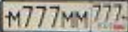

In [ ]:
#!wget https://777nomera.ru/images/os_imagegallery_99/original/8366829.jpg
#!wget https://zakon-kuzbass.ru/assets/images/tickets/30909/c0d50c05d2dbf495d08acd9c4065a1f7e2fa47a1.jpg -O /content/test001.jpg
#!wget https://znaj.ua/images/2019/02/04/z1Gz9QfFDhXqk5TibmHgRHgCBwj84TGmbSC6cJfS.jpeg -O /content/test002.jpg # 2 Номера

import random

nomer_car = 13
path_image = os.path.join('/content/drive/My Drive/DataCars', list_cars[random.choice(range(len(list_cars)))])
#path_image = '/content/image.jpg'

a = time()
image, image_orig, img_shape = prepare_image(path_image)


test_output = model(image.to(device))

w, h, _ = img_shape
mask_rgb = cv2.resize((test_output[0].cpu().detach().numpy().squeeze() > 0.5).astype(np.uint8), dsize=(h, w))


contours, hierarchy = cv2.findContours(mask_rgb.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#image_orig_copy = image_orig.copy()

count_contours = len(contours)
outputs = []
mask_list = []
recog_dict = {}

outputs = find_rect(mask_rgb, image_orig.copy())
# for cont in range(count_contours):

#   # делаем несколько масок
#   mask = np.zeros_like(mask_rgb)
#   mask = cv2.drawContours(mask, [contours[cont]], -1, (255,0,0), 3, cv2.LINE_AA, np.expand_dims(hierarchy[:, cont], axis=1), 1)
#   mask = convex_hull_image(mask).astype(np.uint8)
#   mask_list.append(mask)

#   a3 = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
#   cord = rectDetect.detect([a3 * 255])
# # x1, x2, x3, x4 = cord[0]

#   zones = rectDetect.get_cv_zonesRGB(image_orig.copy(), cord)
#   outputs.append(zones[0])

import crnn
nomer_list = []

alphabet = '1234567890abekmhopctyx'

nclass = len(alphabet) + 1
nc = 3
nh = 256
imgH = 64
preds_size = torch.tensor([33])

converter = utils.strLabelConverter(alphabet)
crnn = crnn.CRNN(imgH, nc, nclass, nh).to(device)
crnn.load_state_dict(torch.load('/content/drive/My Drive/WeightNet/OCR(6)'))
crnn.eval()

for nomer in outputs:
  image = nomer_aug(image=nomer)['image'].unsqueeze(0)
  preds1 = crnn(image.to(device))
  _, preds = preds1.max(2)
  batch = preds.size(1)
  preds = preds.transpose(1, 0).contiguous().view(-1)

  sim_pred = converter.decode(preds.data, preds_size.data, raw=False)
  postpro = re.findall(temp, sim_pred)
  sim_pred = postpro[0] if postpro != [] else 'Unknown'
  nomer_list.append(sim_pred)
  
  if sim_pred != 'Unknown':
    recog_dict[sim_pred] = nomer 



b = time()

print(*nomer_list, b - a, sep=' ')

for k, v in recog_dict.items():
  print(k)
  cv2_imshow(v)

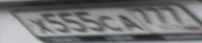

In [ ]:
cv2_imshow(outputs[1])

In [ ]:
#!wget https://777nomera.ru/images/os_imagegallery_99/original/8366829.jpg
#!wget https://zakon-kuzbass.ru/assets/images/tickets/30909/c0d50c05d2dbf495d08acd9c4065a1f7e2fa47a1.jpg -O /content/test001.jpg
#!wget https://znaj.ua/images/2019/02/04/z1Gz9QfFDhXqk5TibmHgRHgCBwj84TGmbSC6cJfS.jpeg -O /content/test002.jpg # 2 Номера

nomer_car = 17
path_image = os.path.join('/content/drive/My Drive/DataCars', list_cars[nomer_car])

a = time()






# rectDetect = rectDetector.RectDetector()


# test1 = [{'masks': cv2.resize(mask_rgb, dsize=(h,w))}]
# cv_img_mask = filters.cv_img_mask(test1)
# arrPoints = rectDetect.detect(cv_img_mask)
# img_1 = rectDetect.get_cv_zonesBGR(image_orig.copy() , arrPoints)[0]
# #plt.imshow(img_1)




#img_mask =cv2.resize((output[img_numb].detach().cpu().numpy().transpose(1,2,0).squeeze() > 0.3).astype(np.uint8), dsize=(h, w))
#path_name = Img_size['orig_image'][img_numb]

#image_orig = np.array(Image.open(path_name))


    # отображаем контуры поверх изображения
#cv2.drawContours(image_orig_copy, contours, -1, (255,0,0), 3, cv2.LINE_AA, hierarchy, 1)
#cv2_imshow(image_orig_copy)






  



b = time()

print(*nomer_list, b - a, sep=' ')

['a227aa777'] o03tt33cc3 1.0013580322265625e-05
